# Model Training

## Reading the data and seting imports


In [2]:
import pickle 
import pandas as pd
import numpy as np
from scipy.stats import zscore

from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, top_k_accuracy_score, roc_curve, auc, classification_report
from sklearn.preprocessing import label_binarize

import matplotlib.pyplot as plt
import seaborn as sns

import random 
random.seed(4)

In [4]:
# Reading the data

with open ('../data/raw/mini_gm_public_v0.1.p', 'rb') as f:
    data = pickle.load(f)

In [5]:
# Flattening the data
# Iterate over the dictionary
rows = []
for syndrome_id, subjects in data.items():
    for subject_id, images in subjects.items():
        for image_id, embedding in images.items():
            rows.append([str(syndrome_id), str(subject_id), str(image_id)] + list(embedding))

column_names = ["syndrome_id", "subject_id", "image_id"] + [f"dim_{i}" for i in range(len(rows[0]) - 3)]
df = pd.DataFrame(rows, columns=column_names)

print(f'len df: {len(df)}')
df.head(2)

len df: 1116


,syndrome_id,subject_id,image_id,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,...,dim_310,dim_311,dim_312,dim_313,dim_314,dim_315,dim_316,dim_317,dim_318,dim_319
0,300000082,595,3543,-0.037180,1.741486,1.206103,-0.451453,-0.736373,1.705392,0.738040,...,1.783927,1.587222,-1.522482,-3.935935,0.00799,0.668852,1.129786,0.097900,-0.768619,0.271600
1,300000082,2638,1633,2.424995,0.179920,2.950325,0.379930,-0.158152,-0.238334,-0.436916,...,-0.665296,0.367323,-2.437823,-2.704050,1.69649,-0.471431,2.529153,1.107004,-3.214602,-1.450313


In [6]:
# Split into test and final df

df_test = df.head(5)
df_final = df.loc[5:]

print(f'len df: {len(df)}')
print(f'len df_test: {len(df_test)}')
print(f'len df_final: {len(df_final)}')

len df: 1116
len df_test: 5
len df_final: 1111


## Preprocessing steps

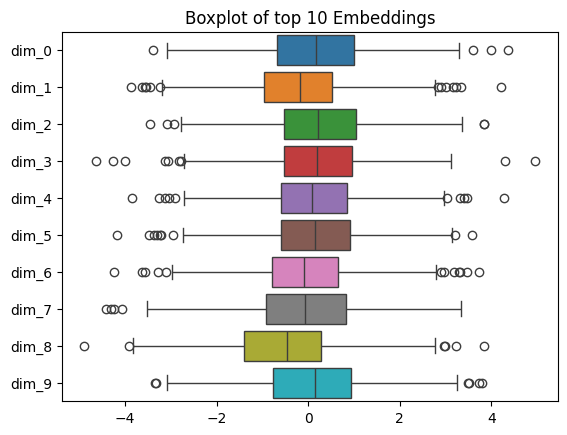

In [14]:
# Checking outliers 
sns.boxplot(data=df_final.iloc[:, 3:13], orient="h")
plt.title("Boxplot of top 10 Embeddings")
plt.show()

In [15]:
# Removing outliers using zscore
# Replacing with the percentile values values that is 3 * the standart deviation
z_scores = zscore(df_final.iloc[:, 3:]).astype(np.float32) 

limite = 3

# Capping / Flooring 
p99 = np.percentile(df_final.iloc[:, 3:], 99, axis=0).astype(np.float32)
p1 = np.percentile(df_final.iloc[:, 3:], 1, axis=0).astype(np.float32)

df_final.iloc[:, 3:] = np.where(z_scores > limite, p99, 
                                    np.where(z_scores < -limite, p1, df_final.iloc[:, 3:].astype(np.float32)))


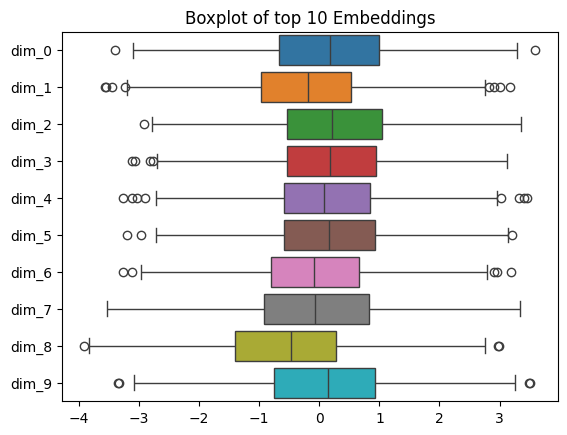

In [16]:
# Checking outliers 
sns.boxplot(data=df_final.iloc[:, 3:13], orient="h")
plt.title("Boxplot of top 10 Embeddings")
plt.show()


In [8]:
# Defining my features and target 
X = df_final.iloc[:, 3:].values
X = pd.DataFrame(X, index=df_final.index)

y = df_final['syndrome_id'].astype('category').cat.codes
y = y.copy()

In [9]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [19]:
y.value_counts()

6    210
7    198
1    136
4    115
8     93
2     89
5     74
0     67
3     65
9     64
Name: count, dtype: int64

In [20]:
y_resampled.value_counts()

8    210
7    210
9    210
3    210
0    210
5    210
1    210
6    210
2    210
4    210
Name: count, dtype: int64

## Setting the model

In [21]:
class KNNClassifier:
    def __init__(self, X, y, k_range=(1, 15), distance_metric='euclidean', n_splits=10):
        """
        Initializes the KNNClassifier with hyperparameters.
        """
        self.k_range = k_range
        self.distance_metric = distance_metric
        self.n_splits = n_splits
        self.best_k = None
        self.final_model = None
        self.results = {}
        self._X = X
        self._y = y

        
        #X = pd.DataFrame(X, index=df.index)  # Convert back to DataFrame for index manipulation
        #y = y.copy()
        ...

    def fit(self):
        """
        Trains the KNN model using cross-validation to find the best k.
        """
        print(f"Using distance metric: {self.distance_metric}")
    
        auc_scores, f1_scores, accuracy_scores, top_k_scores = [], [], [], []
        best_auc, best_f1, best_accuracy, best_top_k = 0, 0, 0, 0
        
        kf = KFold(n_splits=self.n_splits, shuffle=True, random_state=42)

        for k in range(self.k_range[0], self.k_range[1] + 1):
            knn = KNeighborsClassifier(n_neighbors=k, metric=self.distance_metric)
            
            auc_list, f1_list, acc_list, top_k_list = [], [], [], []
            
            for train_idx, test_idx in kf.split(self._X):
                X_train, X_test = self._X.iloc[train_idx], self._X.iloc[test_idx]
                y_train, y_test = self._y.iloc[train_idx], self._y.iloc[test_idx]
                
                knn.fit(X_train, y_train)
                y_pred = knn.predict(X_test)
                y_pred_proba = knn.predict_proba(X_test)
                
                auc_list.append(roc_auc_score(y_test, y_pred_proba, multi_class='ovr'))
                f1_list.append(f1_score(y_test, y_pred, average='weighted'))
                acc_list.append(accuracy_score(y_test, y_pred))
                top_k_list = top_k_accuracy_score(y_test, y_pred_proba, k=2)

            # Compute the mean metrics for this k
            avg_auc, avg_f1, avg_accuracy, avg_top_k = np.mean(auc_list), np.mean(f1_list), np.mean(acc_list), np.mean(top_k_list)
            
            auc_scores.append(avg_auc)
            f1_scores.append(avg_f1)
            accuracy_scores.append(avg_accuracy)
            top_k_scores.append(avg_top_k)

            # Track the best k for each metric
            if avg_auc > best_auc:
                best_auc, self.best_k_auc = avg_auc, k
            if avg_f1 > best_f1:
                best_f1, self.best_k_f1 = avg_f1, k
            if avg_accuracy > best_accuracy:
                best_accuracy, self.best_k_accuracy = avg_accuracy, k
            if avg_top_k > best_top_k:
                best_top_k, self.best_top_k = avg_top_k, k

        self.results = {
            'auc_scores': auc_scores,
            'f1_scores': f1_scores,
            'accuracy_scores': accuracy_scores,
            'top_k_scores': top_k_scores,
            'best_k_auc': self.best_k_auc,
            'best_k_f1': self.best_k_f1,
            'best_k_accuracy': self.best_k_accuracy,
            'best_k_top': self.best_top_k
        }

        # Choose the best k based on AUC
        self.best_k = self.best_k_auc

        print(f"\nBest k based on AUC: {self.best_k_auc}")
        print(f"Best k based on F1-Score: {self.best_k_f1}")
        print(f"Best k based on Accuracy: {self.best_k_accuracy}")
        print(f"Best k based on Top-K: {self.best_top_k}")

        self.final_model = KNeighborsClassifier(n_neighbors=self.best_k, metric=self.distance_metric)
        self.final_model.fit(self._X, self._y)

        avg_auc_best_k = auc_scores[self.best_k_auc - self.k_range[0]]
        avg_f1_best_k = f1_scores[self.best_k_f1 -self.k_range[0]]
        avg_accuracy_best_k = accuracy_scores[self.best_k_accuracy - self.k_range[0]]
        avg_top_k_best_k = accuracy_scores[self.best_top_k - self.k_range[0]]

        # Retornando as médias e o melhor modelo treinado
        print(f"\nAverage AUC for best k ({self.best_k}): {avg_auc_best_k}")
        print(f"Average F1-Score for best k ({self.best_k}): {avg_f1_best_k}")
        print(f"Average Accuracy for best k ({self.best_k}): {avg_accuracy_best_k}")
        print(f"Average Top-k Accuracy for best k ({self.best_k}): {avg_top_k_best_k}")

    def predict(self):
        """
        Predicts class labels for the given input data.
        """
        if self.final_model is None:
            raise ValueError("Model has not been trained. Call fit() first.")
        return self.final_model.predict(self._X)

    def predict_proba(self):
        """
        Predicts class probabilities for the given input data.
        """
        if self.final_model is None:
            raise ValueError("Model has not been trained. Call fit() first.")
        return self.final_model.predict_proba(self._X)

    def get_best_k(self):
        """
        Returns the best k value based on AUC.
        """
        return self.best_k

    def get_results(self):
        """
        Returns the evaluation results from cross-validation.
        """

    def plot_roc_curve(self, y_bin, label, ax):
        y_pred_proba = self.final_model.predict_proba(self._X)

        for i in range(y_bin.shape[1]):  # Loop through each class
            fpr, tpr, _ = roc_curve(y_bin[:, i], y_pred_proba[:, i])
            roc_auc = auc(fpr, tpr)
            ax.plot(fpr, tpr, label=f'{label} - Class {i} (AUC = {roc_auc:.2f})')
            
        return self.results

## Training the model 

### Euclidean Metric

In [22]:
knn_model_euc = KNNClassifier(X, y, k_range=(1, 15), distance_metric='euclidean')
knn_model_euc.fit()

Using distance metric: euclidean

Best k based on AUC: 15
Best k based on F1-Score: 10
Best k based on Accuracy: 15
Best k based on Top-K: 5

Average AUC for best k (15): 0.9520523098512974
Average F1-Score for best k (15): 0.7475048420828945
Average Accuracy for best k (15): 0.7543436293436294
Average Top-k Accuracy for best k (15): 0.7039655727155727


In [23]:
knn_model_euc_smote = KNNClassifier(X_resampled, y_resampled, k_range=(1, 15), distance_metric='euclidean')
knn_model_euc_smote.fit()

Using distance metric: euclidean

Best k based on AUC: 15
Best k based on F1-Score: 1
Best k based on Accuracy: 1
Best k based on Top-K: 4

Average AUC for best k (15): 0.9706063328794066
Average F1-Score for best k (15): 0.8597976040370876
Average Accuracy for best k (15): 0.8728571428571428
Average Top-k Accuracy for best k (15): 0.8290476190476189


### Cosine Metric

In [24]:
knn_model_cos = KNNClassifier(X, y, k_range=(1, 15), distance_metric='cosine')
knn_model_cos.fit()

Using distance metric: cosine

Best k based on AUC: 15
Best k based on F1-Score: 12
Best k based on Accuracy: 12
Best k based on Top-K: 13

Average AUC for best k (15): 0.9650673046641179
Average F1-Score for best k (15): 0.7894343491830955
Average Accuracy for best k (15): 0.7939350064350064
Average Top-k Accuracy for best k (15): 0.7930341055341056


In [25]:
knn_model_cos_smote = KNNClassifier(X_resampled, y_resampled, k_range=(1, 15), distance_metric='cosine')
knn_model_cos_smote.fit()

Using distance metric: cosine

Best k based on AUC: 15
Best k based on F1-Score: 1
Best k based on Accuracy: 1
Best k based on Top-K: 5

Average AUC for best k (15): 0.9894383063911942
Average F1-Score for best k (15): 0.924484047034416
Average Accuracy for best k (15): 0.9271428571428573
Average Top-k Accuracy for best k (15): 0.8895238095238094


## Checking the results

In [26]:
# Generate predictions and display classification report for euclidean 

y_pred_euc = np.argmax(knn_model_euc.predict_proba(), axis=1)  
y_pred_euc_smote = np.argmax(knn_model_euc_smote.predict_proba(), axis=1)  

y_bin_euc_smote = label_binarize(y_resampled, classes=range(10))  

print('Metric : Euclidean\n',classification_report(y, y_pred_euc))
print('\nMetric : Euclidean using SMOTE\n',classification_report(y_resampled, y_pred_euc_smote))

Metric : Euclidean
               precision    recall  f1-score   support

           0       0.83      0.78      0.80        67
           1       0.76      0.90      0.82       136
           2       0.91      0.89      0.90        89
           3       0.69      0.83      0.76        65
           4       0.90      0.77      0.83       115
           5       0.92      0.64      0.75        74
           6       0.76      0.96      0.85       210
           7       0.81      0.79      0.80       198
           8       0.88      0.80      0.84        93
           9       0.90      0.42      0.57        64

    accuracy                           0.81      1111
   macro avg       0.84      0.78      0.79      1111
weighted avg       0.82      0.81      0.81      1111


Metric : Euclidean using SMOTE
               precision    recall  f1-score   support

           0       0.77      0.93      0.84       210
           1       0.76      0.88      0.81       210
           2       0.93  

In [27]:
# Generate predictions and display classification report for Cosine 


y_pred_cos = np.argmax(knn_model_cos.predict_proba(), axis=1)  

y_pred_cos_smote = np.argmax(knn_model_cos_smote.predict_proba(), axis=1)  

y_bin_cos_smote = label_binarize(y_resampled, classes=range(10))  

print('Metric : Cosine\n',classification_report(y, y_pred_cos))
print('\nMetric : Cosine using SMOTE\n',classification_report(y_resampled, y_pred_cos_smote))


Metric : Cosine
               precision    recall  f1-score   support

           0       0.79      0.78      0.78        67
           1       0.85      0.86      0.86       136
           2       0.89      0.96      0.92        89
           3       0.84      0.65      0.73        65
           4       0.82      0.83      0.82       115
           5       0.80      0.72      0.76        74
           6       0.84      0.96      0.90       210
           7       0.81      0.84      0.82       198
           8       0.82      0.85      0.84        93
           9       0.89      0.53      0.67        64

    accuracy                           0.83      1111
   macro avg       0.84      0.80      0.81      1111
weighted avg       0.83      0.83      0.83      1111


Metric : Cosine using SMOTE
               precision    recall  f1-score   support

           0       0.87      0.96      0.91       210
           1       0.92      0.89      0.90       210
           2       0.93      0.

In [28]:
y_pred_cos_smote

array([8, 8, 8, ..., 9, 9, 9], shape=(2100,))

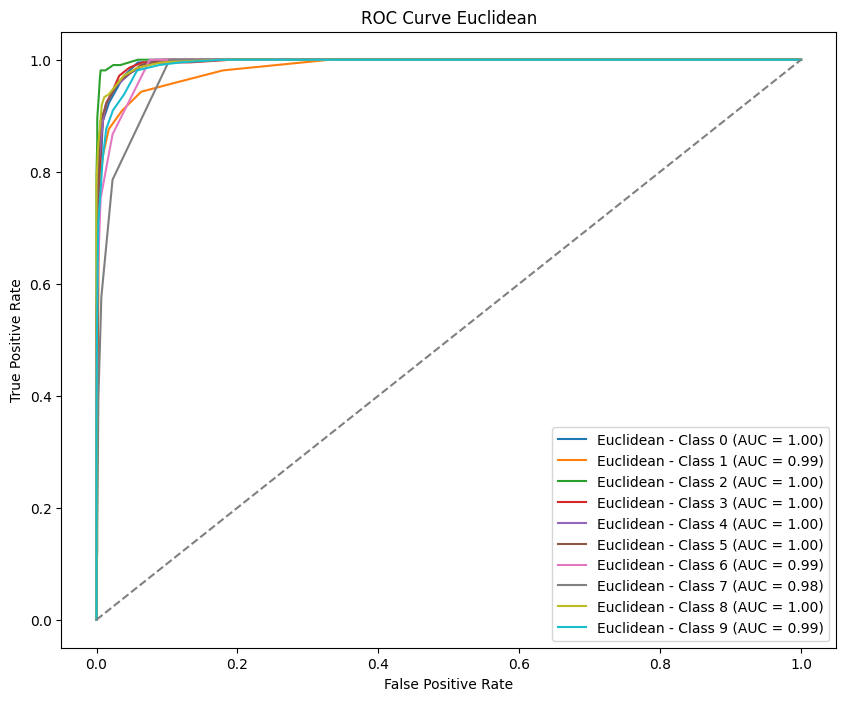

In [29]:
# Plotting the Auc Roc curve for Euclidean Metric
fig, ax = plt.subplots(figsize=(10, 8))
knn_model_euc_smote.plot_roc_curve(y_bin_euc_smote, 'Euclidean', ax)

ax.plot([0, 1], [0, 1], color='gray', linestyle='--')
ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')
plt.title("ROC Curve Euclidean")
plt.legend(loc='lower right')
plt.savefig('../data/images/roc_euclidean.png', bbox_inches='tight')
plt.show()


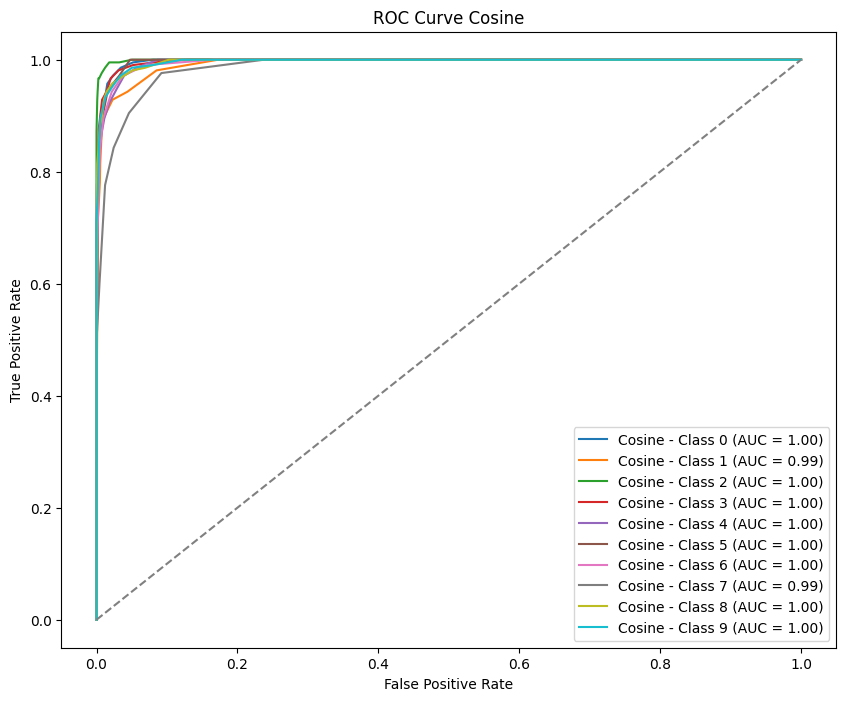

In [30]:
# Plotting the Auc Roc curve for Cosine Metric
fig, ax = plt.subplots(figsize=(10, 8))
knn_model_cos_smote.plot_roc_curve(y_bin_cos_smote, 'Cosine', ax)

ax.plot([0, 1], [0, 1], color='gray', linestyle='--')
ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')
plt.title("ROC Curve Cosine")
plt.legend(loc='lower right')
plt.savefig('../data/images/roc_cosine.png', bbox_inches='tight')
plt.show()

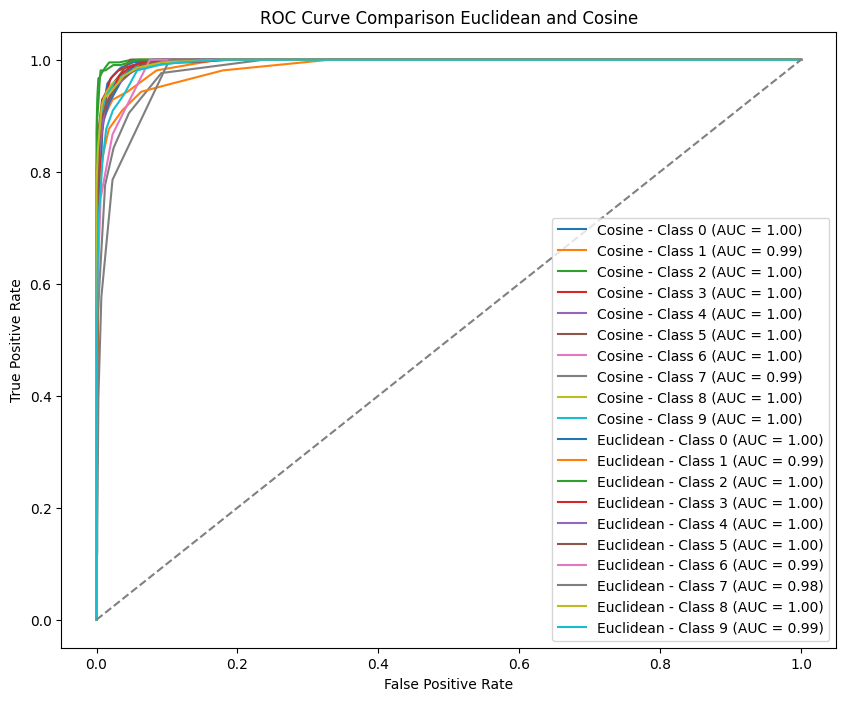

In [31]:
# Plotting the Auc Roc curve for Cosine and Euclidean for comparison
fig, ax = plt.subplots(figsize=(10, 8))
knn_model_cos_smote.plot_roc_curve(y_bin_cos_smote, 'Cosine', ax)
knn_model_euc_smote.plot_roc_curve(y_bin_euc_smote, 'Euclidean', ax)

ax.plot([0, 1], [0, 1], color='gray', linestyle='--')
ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')
plt.title("ROC Curve Comparison Euclidean and Cosine")
plt.legend(loc='lower right')
plt.savefig('../data/images/roc_comparision.png', bbox_inches='tight')
plt.show()
